In [1]:
import h5py as h5

import os 
import numpy as np 
import nbodykit.lab as NBlab
from astropy.utils.misc import NumpyRNGContext
from nbodykit.hod import Zheng07Model, HODModel
import pickle as pk
from pmesh.pm import ParticleMesh, RealField
from nbodykit.lab import FFTPower, ProjectedFFTPower, ArrayMesh
import Pk_library as PKL
import MAS_library as MASL


In [2]:
import matplotlib.pyplot as pl
%matplotlib inline


In [3]:
def setup_hod(hmass, nbar=4e-4, satfrac=0.2, bs=1000, alpha_fid=0.7):
    numdhalos = len(hmass)/bs**3
    numhalos_nbarf = int(nbar * bs**3 * (1-satfrac))
    mcut = hmass[:numhalos_nbarf][-1]
    nsat = satfrac * nbar * bs**3
    mdiff = (hmass - mcut + mcut*1e-3)[:numhalos_nbarf] ** alpha_fid
    msum = mdiff.sum()/nsat
    m1 = msum**(1/alpha_fid)
    mcut = 10**(np.log10(mcut) + 0.1) 
    return mcut, m1

def sample_conditional_HOD(mcut, m1=None, seed=0): 
    ''' sample HOD value based on priors set by Parejko+(2013)
    centrals: 0.5*[1+erf((\log M_h - \log M_cut)/\sigma)]
    satellites: ((M_h - M_0)/M_1)**\alpha
    '''
    np.random.seed(seed)
    m0 = mcut
    if m1 is None: m1 = mcut + 0.5
    hod = np.array([mcut, 0.4, m0, m1, 0.7])
    dhod = np.array([0.15, 0.1, 0.2, 0.3, 0.3])
    #dhod = np.array([0.2, 0.1, 0.5, 0.4, 0.4, 0.5, 0.5])
    _hod = hod + dhod * np.random.uniform(-1, 1, size=(5))
    theta_hod = {'logMmin': _hod[0], 'sigma_logM': _hod[1], 'logM0': _hod[2], 'logM1': _hod[3], 'alpha': _hod[4]}
    return theta_hod


def get_halo_cats(isim, z=0.5, boxsize=1000., ldir = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth_nsubv_vel_10k/', LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'):
    
    LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)

    cosmo_params = LH_cosmo_val_all[isim]
    Om, Ob, h, ns, s8 = cosmo_params
    params = {'flat': True, 'H0': 100*h, 'Om0': Om, 'Ob0': Ob, 'sigma8': s8, 'ns': ns}
    cosmo_nb = NBlab.cosmology.Planck15.clone(
                h=params['H0']/100., 
                Omega0_b=params['Ob0'], 
                Omega0_cdm=params['Om0']-params['Ob0'],
                n_s=params['ns']) 
    Ol = 1 - Om
    Hz = 100.0 * np.sqrt(Om * (1. + z)**3 + Ol) # km/s/(Mpc/h)


    saved = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))
    pos_h_truth = saved['pos_truth']
    lgMass_truth = saved['lgmass_truth']
    vel_h_truth = saved['vel_truth']
    pos_h_mock = saved['pos_mock']
    lgMass_mock = saved['lgmass_mock']
    vel_h_mock = saved['vel_mock']

    pos_types = ['mock', 'truth']
    halos_cats = []
    for pos in pos_types:
        if pos == 'mock':
            real_pos = pos_h_mock
            lgmass = lgMass_mock
            halo_vel = vel_h_mock
        else:
            real_pos = pos_h_truth
            lgmass = lgMass_truth
            halo_vel = vel_h_truth
        group_data = {}  
        group_data['Length']    = np.ones(len(real_pos)) * len(real_pos)
        group_data['Position']  = real_pos
        group_data['Velocity']  = halo_vel
        group_data['Mass']      = 10**lgmass
        # calculate velocity offset
        rsd_factor = (1. + z) / Hz
        group_data['VelocityOffset'] = halo_vel * rsd_factor
        # save to ArryCatalog for consistency
        cat = NBlab.ArrayCatalog(group_data, BoxSize=np.array([boxsize, boxsize, boxsize])) 
        cat['Length'] = len(cat)
        cat.attrs['rsd_factor'] = rsd_factor 

        cat.attrs['Om'] = Om
        cat.attrs['Ob'] = Ob
        cat.attrs['Ol'] = Ol
        cat.attrs['h'] = h 
        cat.attrs['ns'] = ns
        cat.attrs['s8'] = s8
        cat.attrs['Hz'] = Hz # km/s/(Mpc/h)   
        halos = NBlab.HaloCatalog(cat, cosmo=cosmo_nb, redshift=0.5, mdef='vir')     
        halos_cats.append(halos)
    return halos_cats[0], halos_cats[1]

def get_theta_hod(halos, isim, ihod, seed=0, nbar=4e-4, sat_frac=0.2, alpha_sat_fid=0.7, BoxSize=1000.0, LH_file_all = '/mnt/home/spandey/ceph/CHARM/data/LH_points_HOD_cosmo_np_20000.txt'):
    hmass = halos['Mass']
    hmass_sort = np.flip(np.sort(hmass))
    M_min, M1 = setup_hod(hmass_sort, nbar=nbar, satfrac=sat_frac, bs=BoxSize, alpha_fid=alpha_sat_fid)
    M0 = M_min    
    LH_points = np.loadtxt(LH_file_all)
    delta_hod = LH_points[isim + 2000*ihod][:5]
    cosmo_params = LH_points[isim + 2000*ihod][5:]
    DlogMmin, Dsigma_logM, DlogM0, DlogM1, Dalpha = delta_hod
    theta_hod = {'logMmin': np.log10(M_min) + DlogMmin, 'sigma_logM': 0.4 + Dsigma_logM, 'logM0': np.log10(M0) + DlogM0, 
                'logM1': np.log10(M1) + DlogM1, 'alpha': alpha_sat_fid + Dalpha}
    Om, Ob, h, ns, s8, LH_id_cosmo = cosmo_params
    theta_cosmo = {'Om': Om, 'Ob': Ob, 'h': h, 'ns': ns, 'sigma8': s8, 'LH_id_cosmo': LH_id_cosmo}
    return theta_hod, theta_cosmo

def get_gal_cats(halos, theta_hod, boxsize=1000., seed=0):
    hod = halos.populate(Zheng07Model, seed=seed, **theta_hod)
    gtype = hod['gal_type'].compute()
    galsum = {}
    galsum['total'], galsum['number density'] = gtype.size, gtype.size/boxsize**3
    galsum['centrals'], galsum['satellites'] = np.unique(gtype, return_counts=True)[1]
    galsum['fsat'] = galsum['satellites']/galsum['total']
    return hod, galsum

def get_gal_Pk(gal_hod=None, mesh=None, pos_type='rsd', sigma_pos=0.0, boxsize=1000., los=[1,0,0], grid=128, MAS='NGP', compensated=False):
    if mesh is None:
        if pos_type == 'rsd':
            pos = gal_hod['Position'] + gal_hod['VelocityOffset']*los
        else:
            pos = gal_hod['Position']

        pos = (pos.compute()).astype(np.float32)

        if sigma_pos > 0.0:
            sigma_1d = sigma_pos/np.sqrt(3)
            randg = np.random.randn(len(pos),3)*sigma_1d
            pos += randg

        pos = pos % boxsize

        mesh = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(pos, mesh, boxsize, MAS)
        mesh /= np.mean(mesh, dtype=np.float32)
        mesh -= 1.0
    if compensated:
        Pk = PKL.Pk(mesh, boxsize, axis=0, MAS=MAS)
    else:
        Pk = PKL.Pk(mesh, boxsize, axis=0, MAS=None)
    return Pk, mesh

def get_gal_Bk(k1, k2, theta, gal_hod=None, mesh=None, pos_type='rsd', sigma_pos=0.0, boxsize=1000., los=[1,0,0], grid=128, MAS='NGP', compensated=False):
    if mesh is None:
        if pos_type == 'rsd':
            pos = gal_hod['Position'] + gal_hod['VelocityOffset']*los
        else:
            pos = gal_hod['Position']

        pos = pos.compute()
        
        if sigma_pos > 0.0:
            sigma_1d = sigma_pos/np.sqrt(3)
            randg = np.random.randn(len(pos),3)*sigma_1d
            pos += randg

        pos = pos % boxsize

        mesh = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(pos, mesh, boxsize, MAS)
        mesh /= np.mean(mesh, dtype=np.float32)
        mesh -= 1.0
    if compensated:
        Bk = PKL.Bk(mesh, boxsize, k1, k2, theta, MAS, 1)
    else:
        Bk = PKL.Bk(mesh, boxsize, k1, k2, theta, None, 1)
    return Bk, mesh




In [4]:
def get_Pk_Bk(isim, nhod_LH_samp=10, sigma_pos=0.0, nk=12, kmax=0.32):
    saved_j = {'isim': isim, 'sigma_pos': sigma_pos, 'nk': nk, 'kmax': kmax}
    halos_mock, halos_truth = get_halo_cats(isim)
    for ihod in range(nhod_LH_samp):
        theta_hod, theta_cosmo = get_theta_hod(halos_mock, isim, ihod=ihod)
        saved_j[f'theta_hod_{ihod}'] = theta_hod
        saved_j[f'theta_cosmo_{ihod}'] = theta_cosmo
        hod_mock, galsum_mock = get_gal_cats(halos_mock, theta_hod)
        saved_j[f'galsum_mock_{ihod}'] = galsum_mock
        hod_truth, galsum_truth = get_gal_cats(halos_truth, theta_hod)
        saved_j[f'galsum_truth_{ihod}'] = galsum_truth
        Pk_mock, mesh_mock = get_gal_Pk(gal_hod=hod_mock, sigma_pos=sigma_pos)
        Pk_truth, mesh_truth = get_gal_Pk(gal_hod=hod_truth, sigma_pos=sigma_pos)

        indk_sel = np.where((Pk_truth.k3D >= 0.01) & (Pk_truth.k3D <= kmax))[0]    
        Pkmock_sel = Pk_mock.Pk[indk_sel,:]
        Pktruth_sel = Pk_truth.Pk[indk_sel,:]  
        k_Pk = Pk_truth.k3D[indk_sel]          
        len_k_sel = len(indk_sel)
        ds_fac = len_k_sel//nk
        Pk_mock_ds = Pkmock_sel[::ds_fac]
        Pk_truth_ds = Pktruth_sel[::ds_fac]
        k_Pk_ds = k_Pk[::ds_fac]    

        saved_j[f'rsd_Pk_mock_{ihod}'] = Pk_mock_ds
        saved_j[f'rsd_Pk_truth_{ihod}'] = Pk_truth_ds
        saved_j[f'rsd_k_Pk_{ihod}'] = k_Pk_ds

        k1_array = [0.08, 0.16, 0.32]
        theta = np.linspace(0.1, np.pi-0.1, 8)
        saved_j[f'theta_Bk_{ihod}'] = theta
        for k1 in k1_array:
            k2 = k1
            Bk_mock, _ = get_gal_Bk(k1, k2, theta, mesh=mesh_mock)
            Bk_truth, _ = get_gal_Bk(k1, k2, theta, mesh=mesh_truth)

            if k1 == 0.08:
                saved_j[f'rsd_Bk_mock_0p08_{ihod}'] = Bk_mock.B     
                saved_j[f'rsd_Bk_truth_0p08_{ihod}'] = Bk_truth.B
            elif k1 == 0.16:
                saved_j[f'rsd_Bk_mock_0p16_{ihod}'] = Bk_mock.B
                saved_j[f'rsd_Bk_truth_0p16_{ihod}'] = Bk_truth.B
            elif k1 == 0.32:
                saved_j[f'rsd_Bk_mock_0p32_{ihod}'] = Bk_mock.B
                saved_j[f'rsd_Bk_truth_0p32_{ihod}'] = Bk_truth.B

    return saved_j




In [5]:
saved_LH_all = get_Pk_Bk(3, sigma_pos=8.0)
# Pk_truth

/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.80

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.80

Computing bispectrum of the field...
Time to compute bispectrum = 0.79


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.76

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.79


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.75

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.76

Computing bispectrum of the field...
Time to compute bispectrum = 0.76

Computing bispectrum of the field...
Time to compute bispectrum = 0.78


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.81

Computing bispectrum of the field...
Time to compute bispectrum = 0.80


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.79


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.76

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.77


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.76

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.79

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78


/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.10 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.77

Computing bispectrum of the field...
Time to compute bispectrum = 0.78

Computing bispectrum of the field...
Time to compute bispectrum = 0.78


In [24]:
saved_LH_all['galsum_mock_2']


{'total': 443089,
 'number density': 0.000443089,
 'centrals': 336090,
 'satellites': 106999,
 'fsat': 0.24148421648923804}

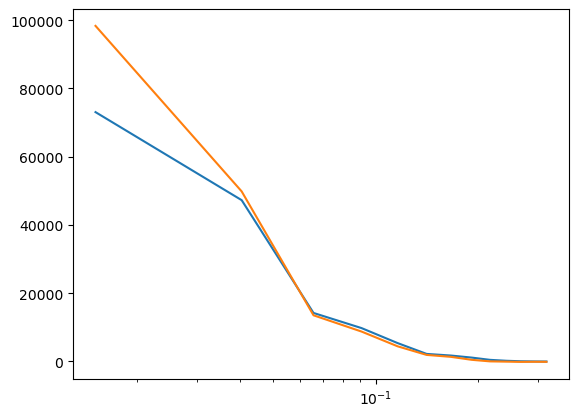

In [15]:
ihod = 6
ell_pk = 1
pl.figure()
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,1], label='mock')
# pl.plot(Pk_truth.k3D, Pk_truth.Pk[:,1], label='truth')
pl.plot(saved_LH_all[f'rsd_k_Pk_{ihod}'], saved_LH_all[f'rsd_Pk_mock_{ihod}'][:,ell_pk], label='mock')
pl.plot(saved_LH_all[f'rsd_k_Pk_{ihod}'], saved_LH_all[f'rsd_Pk_truth_{ihod}'][:,ell_pk], label='truth')

pl.plot(saved_LH_all[f'rsd_k_Pk_{ihod}'], saved_LH_all[f'rsd_Pk_mock_{ihod}'][:,ell_pk], label='mock')
pl.plot(saved_LH_all[f'rsd_k_Pk_{ihod}'], saved_LH_all[f'rsd_Pk_truth_{ihod}'][:,ell_pk], label='truth')


pl.xscale('log')
# pl.yscale('log')



In [41]:
halo_cat_mock, halo_cat_truth = get_halo_cats(0)


In [28]:
ldir = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth_nsubv_vel_10k/'
isim = 5
df = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))
df.keys()




dict_keys(['lgmass_truth', 'pos_truth', 'vel_truth', 'lgmass_mock', 'pos_mock', 'vel_mock', 'pos_rsdx_truth', 'pos_rsdx_mock', 'pos_rsdy_truth', 'pos_rsdy_mock', 'pos_rsdz_truth', 'pos_rsdz_mock'])

In [ ]:
import os, sys 
import numpy as np 
import argparse, json
from pmesh.pm import ParticleMesh, RealField
from nbodykit.lab import FFTPower, ProjectedFFTPower, ArrayMesh

    

def get_power(real_pos, halo_vel, lgmass, cosmo_params, hod_params, z=0.5, boxsize=1000, nbar=4e-4, alpha_sat_fid=0.7, sat_frac=0.2):    
    Om, Ob, h, ns, s8 = cosmo_params
    Ol = 1 - Om
    params = {'flat': True, 'H0': 100*h, 'Om0': Om, 'Ob0': Ob, 'sigma8': s8, 'ns': ns}
    cosmo_nb = NBlab.cosmology.Planck15.clone(
            h=params['H0']/100., 
            Omega0_b=params['Ob0'], 
            Omega0_cdm=params['Om0']-params['Ob0'],
            n_s=params['ns'])     
    Hz = 100.0 * np.sqrt(Om * (1. + z)**3 + Ol) # km/s/(Mpc/h)
    # calculate velocity offset

    mass_argsort = np.flip(np.argsort(lgmass))
    lgmass_sort = lgmass[mass_argsort]

    mcut, m1 = setup_hod(10**lgmass_sort, nbar=nbar, satfrac=sat_frac, bs=boxsize, alpha_fid=alpha_sat_fid)
    p_hod = sample_conditional_HOD(np.log10(mcut), np.log10(m1), seed=0)

    group_data = {}  
    group_data['Length']    = len(real_pos)
    group_data['Position']  = real_pos
    group_data['Velocity']  = halo_vel
    group_data['Mass']      = 10**lgmass
    # calculate velocity offset
    rsd_factor = (1. + z) / Hz
    group_data['VelocityOffset'] = halo_vel * rsd_factor
    # save to ArryCatalog for consistency
    cat = NBlab.ArrayCatalog(group_data, BoxSize=np.array([boxsize, boxsize, boxsize])) 
    cat['Length'] = group_data['Length']
    cat.attrs['rsd_factor'] = rsd_factor 

    cat.attrs['Om'] = Om
    cat.attrs['Ob'] = Ob
    cat.attrs['Ol'] = Ol
    cat.attrs['h'] = h 
    cat.attrs['ns'] = ns
    cat.attrs['s8'] = s8
    cat.attrs['Hz'] = Hz # km/s/(Mpc/h)   
    halos = NBlab.HaloCatalog(cat, cosmo=cosmo_nb, redshift=0.5, mdef='vir')     
    hod = halos.populate(Zheng07Model, seed=0, **p_hod)

    los = [1,0,0]
    pos = hod['Position'] + hod['VelocityOffset']*los

    # hod_test = hod.view()
    gal_pos_truth = hod_test['Position'].compute()

    
    # if num is None:
    layout = pm.decompose(pos)
    gal = pm.paint(pos.compute(), layout=layout)




In [9]:
import pickle as pk
# pos = 'real'
pos = 'rsd'
nbar = 4e-4
sat_frac = 0.2
BoxSize = 1000.
alpha_sat = 0.7
sigma_g = 8
sigma_1d = sigma_g/np.sqrt(3)
isim = LH_cosmo_val

ldir = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth_nsubv_vel_10k/'
# isim = 5
df = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))

lgmass = df['lgmass_mock']
mass_argsort = np.flip(np.argsort(lgmass))
lgmass_sort = lgmass[mass_argsort]


mcut, m1 = setup_hod(10**lgmass_sort, nbar=nbar, satfrac=sat_frac, bs=BoxSize, alpha_fid=alpha_sat)

p_hod = sample_conditional_HOD(np.log10(mcut), np.log10(m1), seed=0)

saved = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))
# saved = {'pos_h_truth': pos_h_truth, 'lgMass_truth': lgMass_truth, 'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'cosmo':cosmo_val_all_test[0,0,0,0,:]}
pos_h_truth = saved['pos_truth']
lgMass_truth = saved['lgmass_truth']
pos_h_mock = saved['pos_mock']
lgMass_mock = saved['lgmass_mock']

pos_h_rsd_mock = saved['pos_rsdx_mock']
pos_h_rsd_truth = saved['pos_rsdx_truth']        

LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
cosmo = LH_cosmo_val_all[isim]

if pos == 'real':
    pos_mock_here = pos_h_mock
    pos_truth_here = pos_h_truth
elif pos == 'rsd':
    pos_mock_here = pos_h_rsd_mock
    pos_truth_here = pos_h_rsd_truth


# pos_h_truth = saved['pos_h_truth']
randg = np.random.randn(len(pos_truth_here),3)*sigma_1d
pos_h_truth = pos_truth_here + randg
pos_h_truth %= 1000

# lgMass_truth = saved['lgMass_truth']
# pos_h_mock = saved['pos_h_mock']
randg = np.random.randn(len(pos_mock_here),3)*sigma_1d
pos_h_mock = pos_mock_here + randg
pos_h_mock %= 1000





In [11]:
Nmu=10
poles=[0, 2, 4]
kmin = 0.001
dk = 0.01



In [13]:
group_data = {}  
group_data['Position']  = pos_h_truth


df_nbkit = {}
df_nbkit['Position'] = pos_h_truth
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
ns_h = 128
# mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# r = NBlab.FFTPower(mesh_orig, mode='1d', dk=0.01)
# Pk_truth_halos = r.power
r = NBlab.FFTPower(mesh_orig, mode='2d', Nmu=Nmu, poles=poles, kmin=kmin, dk=dk)
k, pmu = r.power.data['k'], r.power.data['power'].real[:, Nmu//2:]
pell = np.array([r.poles.data['power_%d'%i] for i in poles]).T
Pk_truth_halos = pell

group_data['Velocity']  = 0.0*pos_h_truth
group_data['Mass']      = 10**lgMass_truth
cat = NBlab.ArrayCatalog(group_data, BoxSize=np.array([Lbox, Lbox, Lbox]))
halos = NBlab.HaloCatalog(cat, cosmo=cosmo_nb, redshift=0.5, mdef='vir')     
hod = halos.populate(Zheng07Model, seed=0, **p_hod) 
hod_test = hod.view()
gal_pos_truth = hod_test['Position'].compute()

df_nbkit = {}
df_nbkit['Position'] = gal_pos_truth
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# r = NBlab.FFTPower(mesh_orig, mode='1d', dk=0.01)
r = NBlab.FFTPower(mesh_orig, mode='2d', Nmu=Nmu, poles=poles, kmin=kmin, dk=dk)
k, pmu = r.power.data['k'], r.power.data['power'].real[:, Nmu//2:]
pell = np.array([r.poles.data['power_%d'%i] for i in poles]).T
Pk_truth_gals = pell
# Pk_truth = r.power




/tmp/ipykernel_922015/1040498945.py:30: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')


In [14]:


group_data = {}  
group_data['Position']  = pos_h_mock


df_nbkit = {}
df_nbkit['Position'] = pos_h_mock
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# ns_h = 256
mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# r = NBlab.FFTPower(mesh_orig, mode='1d', dk=0.01)
r = NBlab.FFTPower(mesh_orig, mode='2d', Nmu=Nmu, poles=poles, kmin=kmin, dk=dk)
k, pmu = r.power.data['k'], r.power.data['power'].real[:, Nmu//2:]
pell = np.array([r.poles.data['power_%d'%i] for i in poles]).T
# Pk_mock_halos = r.power
Pk_mock_halos = pell

group_data['Velocity']  = 0.0*pos_h_mock
group_data['Mass']      = 10**lgMass_mock
cat = NBlab.ArrayCatalog(group_data, BoxSize=np.array([Lbox, Lbox, Lbox]))
halos = NBlab.HaloCatalog(cat, cosmo=cosmo_nb, redshift=0.5, mdef='vir')     
hod = halos.populate(Zheng07Model, seed=0, **p_hod) 
hod_test = hod.view()
gal_pos_mock = hod_test['Position'].compute()

df_nbkit = {}
df_nbkit['Position'] = gal_pos_mock
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# ns_h = 256
mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# r = NBlab.FFTPower(mesh_orig, mode='1d', dk=0.01)
r = NBlab.FFTPower(mesh_orig, mode='2d', Nmu=Nmu, poles=poles, kmin=kmin, dk=dk)
k, pmu = r.power.data['k'], r.power.data['power'].real[:, Nmu//2:]
pell = np.array([r.poles.data['power_%d'%i] for i in poles]).T
# Pk_mock_halos = r.power
Pk_mock_gals = pell
# Pk_mock = r.power




/tmp/ipykernel_922015/455396634.py:10: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
/tmp/ipykernel_922015/455396634.py:31: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')


In [15]:
Pk_mock_gals.shape


(40, 3)

In [22]:
Pk_truth_gals[:,0]


array([855147.92307692+0.j, 740564.77777778+0.j, 457151.38853503+0.j,
       226288.59090909+0.j, 143985.68503937+0.j, 127576.68489893+0.j,
       115829.07462687+0.j,  89681.51824818+0.j,  64256.61407249+0.j,
        51971.01225919+0.j,  44414.07412637+0.j,  43023.87338804+0.j,
        36411.36790366+0.j,  31295.60967185+0.j,  27381.06103994+0.j,
        25248.63275395+0.j,  22789.46719909+0.j,  20499.2941776 +0.j,
        19140.94645309+0.j,  16981.26694784+0.j,  16158.19220779+0.j,
        14973.73748309+0.j,  14553.67117152+0.j,  13616.97228865+0.j,
        13273.25946759+0.j,  12623.73044525+0.j,  12443.82988299+0.j,
        11912.6951314 +0.j,  11575.89019911+0.j,  11618.69741979+0.j,
        11280.5902198 +0.j,  11215.24850555+0.j,  10912.78393238+0.j,
        10974.08668818+0.j,  10670.35265006+0.j,  10656.33280313+0.j,
        10737.79018332+0.j,  10582.84625515+0.j,  10562.92980498+0.j,
        10560.28539399+0.j])

Text(0.5, 1.0, '$\\sigma=$8')

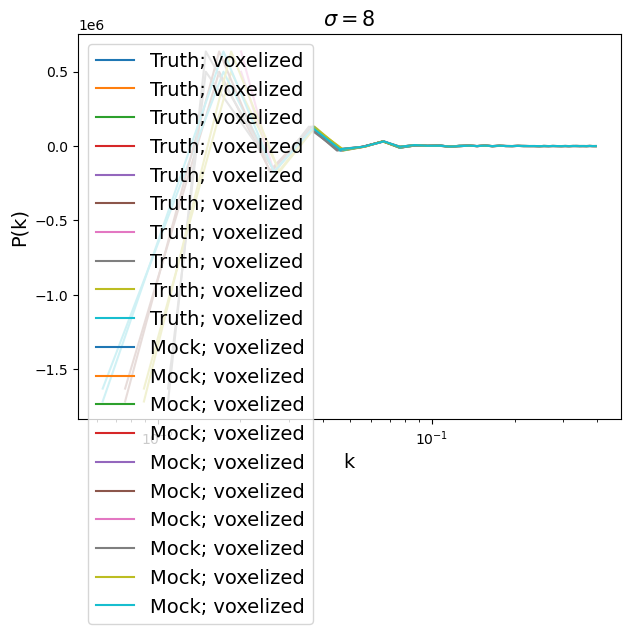

In [27]:
import matplotlib.pyplot as pl
pl.figure(figsize=(7,5))
# pl.plot(Pk_truth_orig['k'], Pk_truth_orig['power'].real, label='Truth')
# pl.plot(Pk_truth['k'], Pk_truth['power'].real, label='Truth; voxelized')
# pl.plot(Pk_mock['k'], Pk_mock['power'].real, label='Mock; voxelized')

pl.plot(k, Pk_truth_gals[:,2].real, label='Truth; voxelized')
pl.plot(k, Pk_mock_gals[:,2].real, label='Mock; voxelized')


# pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag, label='mockxtruth_chirag')
pl.legend(fontsize=14)
pl.xlabel('k', size=14)
pl.ylabel('P(k)', size=14)
pl.xscale('log')
# pl.yscale('log')
# pl.ylim(2e3, 7e4)
pl.title(r'$\sigma=$' + str(sigma_g), size=15)




In [42]:
import numpy as np
import matplotlib.pyplot as plt

from smt.sampling_methods import LHS

import copy
import numpy as np

In [43]:
param_name_all = ['logMmin','sigma_logM','logM0','logM1','alpha']
dhod_all = np.array([0.15, 0.1, 0.2, 0.3, 0.3])
    
nvar_all = len(param_name_all)
xlimits = np.zeros((nvar_all,2))
for jv in range((nvar_all)):
    xlimits[jv,0] = 0.0
    xlimits[jv,1] = 1.0
    
sampling = LHS(xlimits=xlimits,criterion='cm',random_state=int(0))

num = 2000
x = sampling(num)



In [59]:
param_name_all = ['logMmin','sigma_logM','logM0','logM1','alpha']
min_param_val_all = [-0.15, -0.1, -0.2, -0.3, -0.3]
max_param_val_all = [0.15, 0.1, 0.2, 0.3, 0.3]
    
nvar_all = len(param_name_all)
xlimits = np.zeros((nvar_all,2))
for jv in range((nvar_all)):
    xlimits[jv,0] = 0.0
    xlimits[jv,1] = 1.0


sampling = LHS(xlimits=xlimits,criterion='cm',random_state=int(0))

num_LHS = 20000
LHS_points = sampling(num_LHS)

LHS_points_final = np.zeros_like(LHS_points)
for jv in range(nvar_all):
    LHS_points_final[:,jv] = min_param_val_all[jv] + (max_param_val_all[jv] - min_param_val_all[jv]) * LHS_points[:,jv]

LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
id_LH_cosmo_all = np.arange(0, len(LH_cosmo_val_all))
LH_cosmo_val_all_wid = np.concatenate((LH_cosmo_val_all, id_LH_cosmo_all[:,None]), axis=1)
num = num_LHS // len(LH_cosmo_val_all)
LH_cosmo_val_all_wid_tile = np.tile(LH_cosmo_val_all_wid, (num,1))

all_params = np.concatenate((LHS_points_final, LH_cosmo_val_all_wid_tile), axis=1)

# LHS_points_final = np.hstack((np.array([LHS_ids]).T,LHS_points_final))

# Om, Ob, h, ns, s8 = cosmo_params
cosmo_params_names = ['Om','Ob','h','ns','s8', 'LH_cosmo_id']

all_params_names = param_name_all + cosmo_params_names

first_line = ''
for var in all_params_names:
    first_line += str(var) + '     '


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
import copy
import numpy as np
import pathlib
# curr_path = pathlib.Path().absolute()
data_path = '/mnt/home/spandey/ceph/CHARM/data'


param_name_all = ['logMmin','sigma_logM','logM0','logM1','alpha']
min_param_val_all = [-0.15, -0.1, -0.2, -0.3, -0.3]
max_param_val_all = [0.15, 0.1, 0.2, 0.3, 0.3]
    
nvar_all = len(param_name_all)
xlimits = np.zeros((nvar_all,2))
for jv in range((nvar_all)):
    xlimits[jv,0] = 0.0
    xlimits[jv,1] = 1.0


sampling = LHS(xlimits=xlimits,criterion='cm',random_state=int(0))

num_LHS = 20000
LHS_points = sampling(num_LHS)

LHS_points_final = np.zeros_like(LHS_points)
for jv in range(nvar_all):
    LHS_points_final[:,jv] = min_param_val_all[jv] + (max_param_val_all[jv] - min_param_val_all[jv]) * LHS_points[:,jv]

LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
id_LH_cosmo_all = np.arange(0, len(LH_cosmo_val_all))
LH_cosmo_val_all_wid = np.concatenate((LH_cosmo_val_all, id_LH_cosmo_all[:,None]), axis=1)
num = num_LHS // len(LH_cosmo_val_all)
LH_cosmo_val_all_wid_tile = np.tile(LH_cosmo_val_all_wid, (num,1))

all_params = np.concatenate((LHS_points_final, LH_cosmo_val_all_wid_tile), axis=1)

cosmo_params_names = ['Om','Ob','h','ns','s8', 'LH_cosmo_id']

all_params_names = param_name_all + cosmo_params_names

first_line = ''
for var in all_params_names:
    first_line += str(var) + '     '


np.savetxt(data_path + '/LH_points_HOD_cosmo_np_' + str(num_LHS) + '.txt',all_params,header=first_line)



In [1]:
import h5py as h5
import dill
import sys, os 
import numpy as np 
import nbodykit.lab as NBlab
from astropy.utils.misc import NumpyRNGContext
from nbodykit.hod import Zheng07Model, HODModel
import pickle as pk
from pmesh.pm import ParticleMesh, RealField
from nbodykit.lab import FFTPower, ProjectedFFTPower, ArrayMesh
import Pk_library as PKL
import MAS_library as MASL
import galactic_wavelets as gw
import torch
import torch


def setup_hod(hmass, nbar=4e-4, satfrac=0.2, bs=1000, alpha_fid=0.7):
    numdhalos = len(hmass)/bs**3
    numhalos_nbarf = int(nbar * bs**3 * (1-satfrac))
    mcut = hmass[:numhalos_nbarf][-1]
    nsat = satfrac * nbar * bs**3
    mdiff = (hmass - mcut + mcut*1e-3)[:numhalos_nbarf] ** alpha_fid
    msum = mdiff.sum()/nsat
    m1 = msum**(1/alpha_fid)
    mcut = 10**(np.log10(mcut) + 0.1) 
    return mcut, m1

def sample_conditional_HOD(mcut, m1=None, seed=0): 
    ''' sample HOD value based on priors set by Parejko+(2013)
    centrals: 0.5*[1+erf((\log M_h - \log M_cut)/\sigma)]
    satellites: ((M_h - M_0)/M_1)**\alpha
    '''
    np.random.seed(seed)
    m0 = mcut
    if m1 is None: m1 = mcut + 0.5
    hod = np.array([mcut, 0.4, m0, m1, 0.7])
    dhod = np.array([0.15, 0.1, 0.2, 0.3, 0.3])
    #dhod = np.array([0.2, 0.1, 0.5, 0.4, 0.4, 0.5, 0.5])
    _hod = hod + dhod * np.random.uniform(-1, 1, size=(5))
    theta_hod = {'logMmin': _hod[0], 'sigma_logM': _hod[1], 'logM0': _hod[2], 'logM1': _hod[3], 'alpha': _hod[4]}
    return theta_hod


def get_halo_cats(isim, z=0.5, boxsize=1000., ldir = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth_nsubv_vel_10k/', LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'):
    
    LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)

    cosmo_params = LH_cosmo_val_all[isim]
    Om, Ob, h, ns, s8 = cosmo_params
    params = {'flat': True, 'H0': 100*h, 'Om0': Om, 'Ob0': Ob, 'sigma8': s8, 'ns': ns}
    cosmo_nb = NBlab.cosmology.Planck15.clone(
                h=params['H0']/100., 
                Omega0_b=params['Ob0'], 
                Omega0_cdm=params['Om0']-params['Ob0'],
                n_s=params['ns']) 
    Ol = 1 - Om
    Hz = 100.0 * np.sqrt(Om * (1. + z)**3 + Ol) # km/s/(Mpc/h)


    saved = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))
    pos_h_truth = saved['pos_truth']
    lgMass_truth = saved['lgmass_truth']
    vel_h_truth = saved['vel_truth']
    pos_h_mock = saved['pos_mock']
    lgMass_mock = saved['lgmass_mock']
    vel_h_mock = saved['vel_mock']

    pos_types = ['mock', 'truth']
    halos_cats = []
    for pos in pos_types:
        if pos == 'mock':
            real_pos = pos_h_mock
            lgmass = lgMass_mock
            halo_vel = vel_h_mock
        else:
            real_pos = pos_h_truth
            lgmass = lgMass_truth
            halo_vel = vel_h_truth
        group_data = {}  
        group_data['Length']    = np.ones(len(real_pos)) * len(real_pos)
        group_data['Position']  = real_pos
        group_data['Velocity']  = halo_vel
        group_data['Mass']      = 10**lgmass
        # calculate velocity offset
        rsd_factor = (1. + z) / Hz
        group_data['VelocityOffset'] = halo_vel * rsd_factor
        # save to ArryCatalog for consistency
        cat = NBlab.ArrayCatalog(group_data, BoxSize=np.array([boxsize, boxsize, boxsize])) 
        cat['Length'] = len(cat)
        cat.attrs['rsd_factor'] = rsd_factor 

        cat.attrs['Om'] = Om
        cat.attrs['Ob'] = Ob
        cat.attrs['Ol'] = Ol
        cat.attrs['h'] = h 
        cat.attrs['ns'] = ns
        cat.attrs['s8'] = s8
        cat.attrs['Hz'] = Hz # km/s/(Mpc/h)   
        halos = NBlab.HaloCatalog(cat, cosmo=cosmo_nb, redshift=0.5, mdef='vir')     
        halos_cats.append(halos)
    return halos_cats[0], halos_cats[1]

def get_theta_hod(halos, isim, ihod, seed=0, nbar=4e-4, sat_frac=0.2, alpha_sat_fid=0.7, BoxSize=1000.0, LH_file_all = '/mnt/home/spandey/ceph/CHARM/data/LH_points_HOD_cosmo_np_20000.txt'):
    hmass = halos['Mass']
    hmass_sort = np.flip(np.sort(hmass))
    M_min, M1 = setup_hod(hmass_sort, nbar=nbar, satfrac=sat_frac, bs=BoxSize, alpha_fid=alpha_sat_fid)
    M0 = M_min    
    LH_points = np.loadtxt(LH_file_all)
    delta_hod = LH_points[isim + 2000*ihod][:5]
    cosmo_params = LH_points[isim + 2000*ihod][5:]
    DlogMmin, Dsigma_logM, DlogM0, DlogM1, Dalpha = delta_hod
    theta_hod = {'logMmin': np.log10(M_min) + DlogMmin, 'sigma_logM': 0.4 + Dsigma_logM, 'logM0': np.log10(M0) + DlogM0, 
                'logM1': np.log10(M1) + DlogM1, 'alpha': alpha_sat_fid + Dalpha}
    Om, Ob, h, ns, s8, LH_id_cosmo = cosmo_params
    theta_cosmo = {'Om': Om, 'Ob': Ob, 'h': h, 'ns': ns, 'sigma8': s8, 'LH_id_cosmo': LH_id_cosmo}
    return theta_hod, theta_cosmo

def get_gal_cats(halos, theta_hod, boxsize=1000., seed=0):
    hod = halos.populate(Zheng07Model, seed=seed, **theta_hod)
    gtype = hod['gal_type'].compute()
    galsum = {}
    galsum['total'], galsum['number density'] = gtype.size, gtype.size/boxsize**3
    galsum['centrals'], galsum['satellites'] = np.unique(gtype, return_counts=True)[1]
    galsum['fsat'] = galsum['satellites']/galsum['total']
    return hod, galsum

def get_gal_mesh_Pk(gal_hod=None, mesh=None, pos_type='rsd', sigma_pos=0.0, boxsize=1000., los=[1,0,0], grid=128, MAS='NGP', compensated=False, return_Pk=True):
    if mesh is None:
        if pos_type == 'rsd':
            pos = gal_hod['Position'] + gal_hod['VelocityOffset']*los
        else:
            pos = gal_hod['Position']

        pos = (pos.compute()).astype(np.float32)

        if sigma_pos > 0.0:
            sigma_1d = sigma_pos/np.sqrt(3)
            randg = np.random.randn(len(pos),3)*sigma_1d
            pos += randg

        pos = pos % boxsize

        mesh = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(pos, mesh, boxsize, MAS)
        mesh /= np.mean(mesh, dtype=np.float32)
        mesh -= 1.0
    if return_Pk:
        if compensated:
            Pk = PKL.Pk(mesh, boxsize, axis=0, MAS=MAS)
        else:
            Pk = PKL.Pk(mesh, boxsize, axis=0, MAS=None)
        return Pk, mesh
    else:
        return mesh

def get_gal_Bk(k1, k2, theta, gal_hod=None, mesh=None, pos_type='rsd', sigma_pos=0.0, boxsize=1000., los=[1,0,0], grid=128, MAS='NGP', compensated=False):
    if mesh is None:
        if pos_type == 'rsd':
            pos = gal_hod['Position'] + gal_hod['VelocityOffset']*los
        else:
            pos = gal_hod['Position']

        pos = pos.compute()
        
        if sigma_pos > 0.0:
            sigma_1d = sigma_pos/np.sqrt(3)
            randg = np.random.randn(len(pos),3)*sigma_1d
            pos += randg

        pos = pos % boxsize

        mesh = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(pos, mesh, boxsize, MAS)
        mesh /= np.mean(mesh, dtype=np.float32)
        mesh -= 1.0
    if compensated:
        Bk = PKL.Bk(mesh, boxsize, k1, k2, theta, MAS, 1)
    else:
        Bk = PKL.Bk(mesh, boxsize, k1, k2, theta, None, 1)
    return Bk, mesh




In [2]:
# def get_wavelets_all_hods(isim, nhod_LH_samp=10, sigma_pos=8.0, nk=12, kmax=0.32):
    # saved_j = {'isim': isim, 'sigma_pos': sigma_pos, 'nk': nk, 'kmax': kmax}
isim = 0
sigma_pos = 8.0
nk = 12
kmax = 0.32
nhod_LH_samp = 10
halos_mock, halos_truth = get_halo_cats(isim)


In [3]:
grid = 128
mesh_mock_all = np.zeros((nhod_LH_samp, grid, grid, grid), dtype=np.float32)
mesh_truth_all = np.zeros((nhod_LH_samp, grid, grid, grid), dtype=np.float32)
for ihod in range(nhod_LH_samp):
    theta_hod, theta_cosmo = get_theta_hod(halos_mock, isim, ihod=ihod)
    # saved_j[f'theta_hod_{ihod}'] = theta_hod
    # saved_j[f'theta_cosmo_{ihod}'] = theta_cosmo
    hod_mock, galsum_mock = get_gal_cats(halos_mock, theta_hod)
    # saved_j[f'galsum_mock_{ihod}'] = galsum_mock
    hod_truth, galsum_truth = get_gal_cats(halos_truth, theta_hod)
    # saved_j[f'galsum_truth_{ihod}'] = galsum_truth


    # Pk_mock, mesh_mock = get_gal_Pk(gal_hod=hod_mock, sigma_pos=sigma_pos)
    # Pk_truth, mesh_truth = get_gal_Pk(gal_hod=hod_truth, sigma_pos=sigma_pos)
    mesh_mock = get_gal_mesh_Pk(gal_hod=hod_mock, sigma_pos=sigma_pos, return_Pk=False)
    mesh_truth = get_gal_mesh_Pk(gal_hod=hod_truth, sigma_pos=sigma_pos, return_Pk=False)
    mesh_mock_all[ihod] = mesh_mock
    mesh_truth_all[ihod] = mesh_truth



/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/mnt/home/spa

In [20]:
kmax = 0.32
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
J = 3
Q = 2
kc = 2*np.pi*kmax/3 # Cutoff frequency of the mother wavelet (in px^-1 units)
moments = [1/2, 1, 2]


df = torch.from_numpy(mesh_truth_all).to(device)
df_shape = df.shape
N = df_shape[0]
wst_op = gw.ScatteringOp(df_shape[1:], J, Q,
                        moments=moments,
                        kc=kc,
                        scattering=True,
                        device=device)



Computing wavelets...


Done!


In [24]:
# df_shape[1:]
torch.Size([128, 128, 128])


torch.Size([128, 128, 128])

In [21]:
# result = torch.vmap(wst_op)(df)                        
# s0_truth, s1_truth, s2_truth = wst_op(df)
saved_j = {}
for js in range(nhod_LH_samp):
    s0, s1, s2 = wst_op(df[js])
    saved_j[f's0_truth_{js}'] = s0.cpu().numpy()
    saved_j[f's1_truth_{js}'] = s1.cpu().numpy()
    saved_j[f's2_truth_{js}'] = s2.cpu().numpy()


Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S

In [17]:
s0_truth.shape, s1_truth.shape, s2_truth.shape


(torch.Size([3, 10]), torch.Size([3, 6, 10]), torch.Size([3, 15, 1, 1]))